In [1]:
from cmapPy.pandasGEXpress import parse
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from GSVA import gsva

First I import the dataset. Since the dataset is in .gct format, I use cmapPy to parse it.

In [2]:
gct_data = parse.parse("PAAD.gct")
print gct_data

GCT1.3
src: PAAD.gct
data_df: [18465 rows x 183 columns]
row_metadata_df: [18465 rows x 0 columns]
col_metadata_df: [183 rows x 124 columns]


It contains three components:
- data_df: this contains the pandas dataframe object with the gene expressions
- row_metadata_df and col_metadata_df : contains details and metadata information related to the rows and columns

In [3]:
df = gct_data.data_df

In [4]:
num_b4_drop = df.shape[0]
df = df.dropna() # Drops rows with NaN values
num_af_drop = df.shape[0]
print "1 A) Number of genes that had NaNs: ", num_b4_drop - num_af_drop

1 A) Number of genes that had NaNs:  4367


1 B) Gene Expression Distribution across all samples


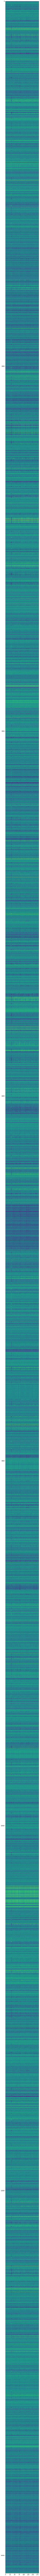

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 400)
ax.imshow(df)
print "1 B) Gene Expression Distribution across all samples"
fig.savefig('gene-expression.png')

Now we need to separate out Neuroendocrine tumors. For that I perform Principle Component Analysis in the Genes, to reduce the dimensions to 2. This will help us separate out the samples.

In [6]:
X = df.values.transpose()

pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

`histological_type_other` is present in col_metadata_df.

2 A,B,C): Plotting whole data using PCA with colouring based on ‘histological_type_other’


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


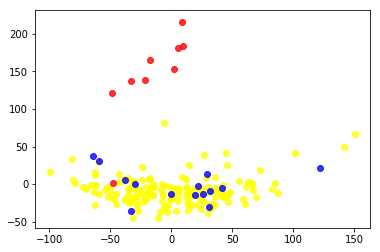

In [7]:
X_pca = pca.transform(X)

X_pca_neuroendocrine = []
X_pca_adenocarcinoma = []
X_pca_others = []

indices = []
for i in range(X_pca.shape[0]):
    if "neuroendocrine" in str(gct_data.col_metadata_df["histological_type_other"].values[i]):
        X_pca_neuroendocrine.append(X_pca[i])
    elif "adenocarcinoma" in str(gct_data.col_metadata_df["histological_type_other"].values[i]):
        X_pca_adenocarcinoma.append(X_pca[i])
        indices.append(i)
    else:
        X_pca_others.append(X_pca[i])

X_pca_neuroendocrine = np.array(X_pca_neuroendocrine).astype(np.float32)
X_pca_adenocarcinoma = np.array(X_pca_adenocarcinoma).astype(np.float32)
X_pca_others = np.array(X_pca_others).astype(np.float32)

print "2 A,B,C): Plotting whole data using PCA with colouring based on ‘histological_type_other’"

fig, ax = plt.subplots()
ax.scatter(X_pca_others[:, 0], X_pca_others[:, 1], c='yellow', alpha=0.8, label="Others")
ax.scatter(X_pca_adenocarcinoma[:, 0], X_pca_adenocarcinoma[:, 1], c='b', alpha=0.8, label="adenocarcinoma")
ax.scatter(X_pca_neuroendocrine[:, 0], X_pca_neuroendocrine[:, 1], c='r', alpha=0.8, label="neuroendocrine")
fig.show()

This analysis shows two main things:
- Just two dimensions are sufficient to separate out neuroendocrine tumours from the rest of the samples
- However, two dimensions cannot separate out adenocarcinoma tumours from the rest of the samples.

In [8]:
print "2 D): PCA explained variance ratio", pca.explained_variance_ratio_

df_subset = df.iloc[:,indices]

2 D): PCA explained variance ratio [0.17050849 0.14845686]


3 A) Gene Expression for pancreatic adenocarcinoma


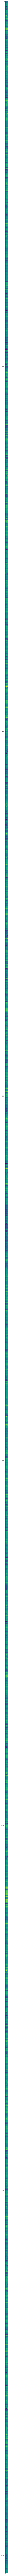

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 400)
ax.imshow(df_subset)
print "3 A) Gene Expression for pancreatic adenocarcinoma"
fig.savefig('gene-expression-adenocarcinoma.png')

In [10]:
gensets_df = pd.read_csv("type1_IFN.txt")

To run GSVA. We need to setup a few things.
- We need to add a column with label 'name' that contains the names of the members in genesets.
- We need to rename the index of the expression_df to 'gene_name'
- We need to rename the column name in the genesets to 'member'

In [11]:
gensets_df["name"] = ["Tumors"]*gensets_df.shape[0]

df.index.name = "gene-name"
gensets_df.rename(columns={"IFIT1": "member"},inplace=True)
pathways_df = gsva(df_subset,gensets_df)

In [12]:
print "3 B) Running GSVA. Following is the Pathways DF generated by GSVA"
pathways_df.head()

3 B) Running GSVA. Following is the Pathways DF generated by GSVA


aab1-Primary solid Tumor  aabh-Primary solid Tumor  \
name                                                         
Tumors                  0.468501                 -0.411514   

        aabi-Primary solid Tumor  6879-Primary solid Tumor  \
name                                                         
Tumors                  -0.55935                  0.640716   

        a45n-Solid Tissue Normal  a45n-Primary solid Tumor  \
name                                                         
Tumors                  0.542332                 -0.133471   

        7289-Primary solid Tumor  8519-Primary solid Tumor  \
name                                                         
Tumors                 -0.391842                 -0.518825   

        a4bk-Primary solid Tumor  a77p-Primary solid Tumor  \
name                                                         
Tumors                  0.558169                 -0.519488   

        a77q-Primary solid Tumor  a9tj-Metastatic  a9tj-Primary solid Tumor  \
name                                                                          
Tumors                  0.666328        -0.681608                 -0.282967   

        a77e-Primary solid Tumor  
name                              
Tumors                  0.534527

3 C) Distribution of GSVA scores for samples


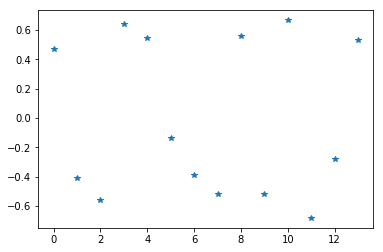

In [13]:
fig, ax = plt.subplots()
v = []
for i in range(pathways_df.shape[1]):
    v.append(pathways_df.iloc[0,i])
ax.plot(v,'*')
print "3 C) Distribution of GSVA scores for samples"
fig.savefig("pathways.png")

We can clearly see that GSVA scores segregate samples into subtypes. One: score > 0 and the other score < 0